# Specific Test II. Lens Finding

**Task**: Build a model classifying the images from \easy directory into lenses using PyTorch or Keras. Evaluate your algorithm on the images from \hard directory; note that only 20% of them have labels available, you can use the rest to train the domain adaptation model or other model of your choice. Pick the most appropriate approach and discuss your strategy.

**Dataset Description**: A dataset comprising images with and without strong lenses. Images in three different filters are available for each object. Description of columns of files containing labels (easy_test.csv and hard_test_cut.csv) is in header.txt. Dataset can be found in this link **[dataset](https://drive.google.com/file/d/1K5cJbC9rfTuUIYVF-AL0NKXNvpXbH9-A/view?usp=sharing)**

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from astropy.io import fits


cudnn.benchmark = True
plt.ion()   # interactive mode|

## Build custom dataset and dataloader

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CustomTrainingDataset(Dataset):
    def __init__(self, root_dir:int, label_path:str, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.label_file = pd.read_csv(label_path).sort_values(by='ID')
        self.labels = self.label_file['no_source'].to_numpy()  
        self.classes = list(set(self.labels))
        self.images_path = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images_path[idx]) 
        with fits.open(image_path) as hdul:
            image = hdul[0].data
        label = torch.tensor(self.labels[idx], device=DEVICE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [3]:
class CustomValidationDataset(Dataset):
    def __init__(self, root_dir:int, label_path:str, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.label_file = pd.read_csv(label_path).sort_values(by='ID')
        self.labels = self.label_file['no_source'].to_numpy()
        # All data that can be used for validation and domain adaptation
        self.all_images_path = sorted(os.listdir(root_dir))
        # Only data that we use for validation
        self.val_images_path = self._select_validation_data()

    def _select_validation_data(self):
        data_for_validation = list(self.label_file['ID'])
        image_prefix = self.all_images_path[0][:11]
        return ["{}-{}.fits".format(image_prefix,file_id) for file_id in data_for_validation]

    def __len__(self):
        return len(self.val_images_path)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.val_images_path[idx]) 
        with fits.open(image_path) as hdul:
            image = hdul[0].data
        label = torch.tensor(self.labels[idx], device=DEVICE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [4]:
BATCH_SIZE=10


class MinMaxNormalization(object):
    def __call__(self, tensor):
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        return (tensor - min_val) / (max_val - min_val)
    
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        MinMaxNormalization()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        MinMaxNormalization()
    ]),
}


train_dataset = CustomTrainingDataset("challenge_2_ML4Science/lens_finding/easy/Band1","challenge_2_ML4Science\lens_finding\easy_test.csv",data_transforms['train'])
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

val_dataset = CustomValidationDataset("challenge_2_ML4Science/lens_finding/hard/Band1", "challenge_2_ML4Science\lens_finding\hard_test_cut.csv",data_transforms['val'])
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE)

dataloaders = {
    'train':train_dataloader,
    'val':val_dataloader
}
dataset_sizes = {
    "train":len(train_dataset),
    "val": len(val_dataset),
    }

Feature batch shape: torch.Size([10, 1, 101, 101])
Labels batch shape: torch.Size([10])
0


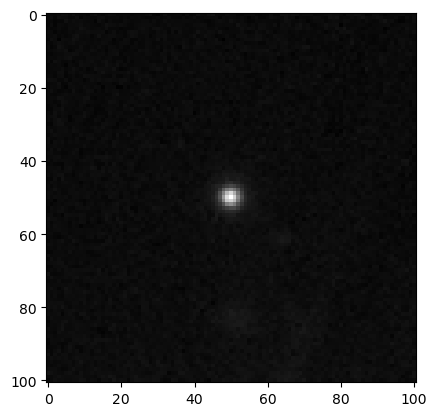

Label: 1


In [5]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img.get_device())
img = img.cpu().numpy()

label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

## Build Neural Network Architecture

The neural network is based on restnet50 architecture, but a convolutional layer is added in the beginning of the layer to single kernel image data. In this model, we remove the fully connected layer in restnet and replace it with sequential linear layer 

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        resnet_weight = ResNet50_Weights.DEFAULT
        self.resnet = resnet50(weights=resnet_weight)
        num_ftrs = self.resnet.fc.in_features
        linear_relu_stack = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        self.resnet.fc = linear_relu_stack

    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet(x)
        return x

In [7]:
# Create the model
model = NeuralNetwork()
model.to(DEVICE)

# Test the model forward method on input data
train_features, train_labels = next(iter(train_dataloader))
with torch.no_grad():
    model_output = model(train_features)

In [8]:
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [9]:
print(model_output.shape)

torch.Size([10, 2])


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(1,num_epochs+1):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                size = len(dataloaders[phase].dataset)
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    current_loss = loss.item()
                    current =  batch * BATCH_SIZE + len(inputs)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    if batch % 100 == 0:
                        print(f"Current loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}]")

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [11]:
lr = 1e-3
# Setup optimizer as usual
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
model_ft = train_model(model, loss_fn, optimizer , exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
# torch.save(model.state_dict(), 'model_weights_challenge2_no_da_train1.pth')

# Load Model and Plot Prediction

In [12]:
model.load_state_dict(torch.load('model_weights_challenge2_no_da.pth'))

<All keys matched successfully>

In [13]:
def plot_model_prediction(batch_images, actual_label, predicted_label):
    num_images = batch_images.shape[0]

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        # Extract the image from the batch_images
        image = batch_images[i, 0]  # Assuming grayscale images
        # Plot the image
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title("pred: {}, actual: {}".format(predicted_label[i],actual_label[i]))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

idx_to_class = {
    0: "lensed",
    1: "no lense"
}

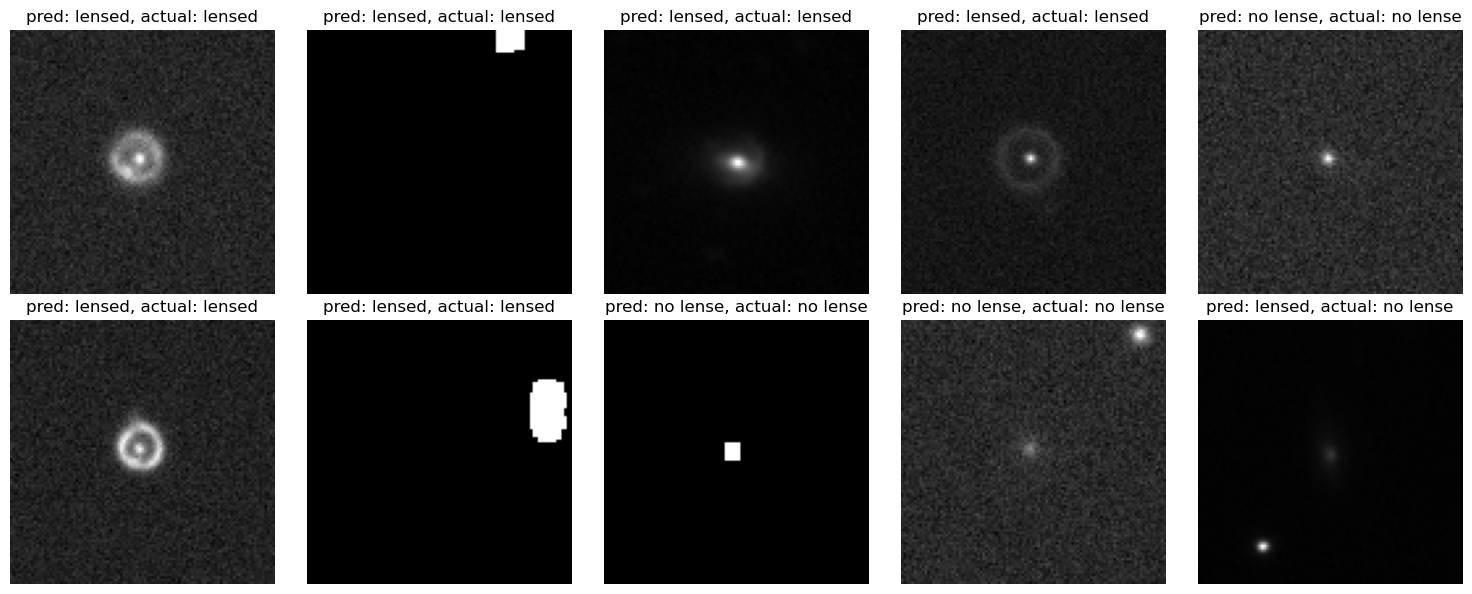

In [14]:
model.eval()
with torch.no_grad():
    inputs, label = next(iter(val_dataloader))
    class_output = model(inputs)
    _, preds = torch.max(class_output, 1)

plot_model_prediction(inputs.cpu(),
                      [idx_to_class[idx] for idx in label.cpu().numpy()], 
                      [idx_to_class[idx] for idx in preds.cpu().numpy()])

# Plot ROC

In [15]:
actual_test_labels = []
predicted_test_labels = []
for batch, (test_data, test_label) in enumerate(val_dataloader):
    model.eval()
    with torch.no_grad():
        prediction_score= model(test_data)
        _, prediction_output = torch.max(prediction_score,1)
        predicted_test_labels.extend(prediction_output.cpu().numpy())
    actual_test_labels.extend(test_label.cpu().numpy())

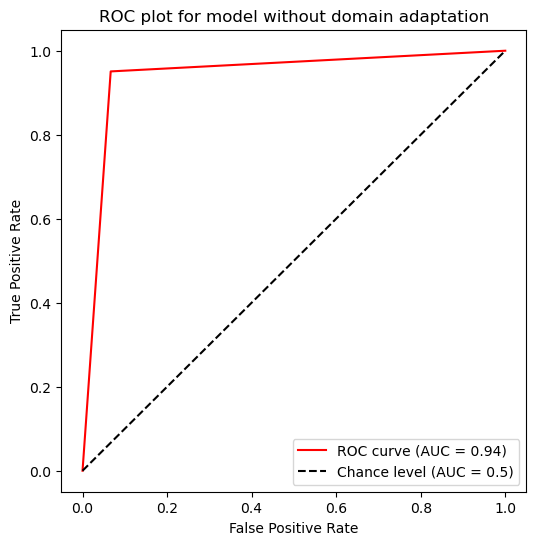

In [16]:
from itertools import cycle

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
RocCurveDisplay.from_predictions(
    actual_test_labels,
    predicted_test_labels,
    name=f"ROC curve",
    color='red',
    ax=ax,
    plot_chance_level=True,
)

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC plot for model without domain adaptation",
)